In [107]:
#https://www.tensorflow.org/tutorials/interpretability/integrated_gradients
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [108]:
#
# load the model to do IG analysis
#
model = keras.models.load_model("3-conv-32-layer-1-dense.model_00h")
model.summary()

Model: "my_functional_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30, 30, 12)]      0         
                                                                 
 sequential (Sequential)     (None, 30, 30, 12)        0         
                                                                 
 my_conv2d_1 (Conv2D)        (None, 28, 28, 32)        3488      
                                                                 
 my_pooling_1 (MaxPooling2D)  (None, 14, 14, 32)       0         
                                                                 
 my_conv2d_2 (Conv2D)        (None, 12, 12, 64)        18496     
                                                                 
 my_pooling_2 (MaxPooling2D)  (None, 6, 6, 64)         0         
                                                                 
 my_conv2d_3 (Conv2D)        (None, 4, 4, 128) 

In [109]:
#
# Function to return input data as an numpy array
#
def prepare(filepath):
    IMG_SIZE = 30
    number_channels = 12
    f = netCDF4.Dataset(filepath)
    abv = f.variables['absvprs']
    nx = np.size(abv[0,0,:])
    ny = np.size(abv[0,:,0])
    nz = np.size(abv[:,0,0])
    #print('Dimension of input NETCDF is: ',nx,ny,nz)
    a2 = np.zeros((nx,ny,number_channels))
    for i in range(a2.shape[0]):
        for j in range(a2.shape[1]):
            a2[i,j,0] = abv[1,j,i]    # abs vort at 950 mb
    rel = f.variables['rhprs']
    for i in range(a2.shape[0]):
        for j in range(a2.shape[1]):
            a2[i,j,1] = rel[7,j,i]    # RH at 750 mb
    sfc = f.variables['pressfc']
    for i in range(a2.shape[0]):
        for j in range(a2.shape[1]):
            a2[i,j,2] = sfc[j,i]      # surface pressure
    tmp = f.variables['tmpprs']
    for i in range(a2.shape[0]):
        for j in range(a2.shape[1]):
            a2[i,j,3] = tmp[15,j,i]   # temperature at 400 mb
    tsf = f.variables['tmpsfc']
    for i in range(a2.shape[0]):
        for j in range(a2.shape[1]):
            a2[i,j,4] = tsf[j,i]      # surface temperature
    ugr = f.variables['ugrdprs']
    for i in range(a2.shape[0]):
        for j in range(a2.shape[1]):
            a2[i,j,5] = ugr[3,j,i]    # u-wind at 900 mb
            a2[i,j,6] = ugr[17,j,i]   # u-wind at 300 mb
    vgr = f.variables['vgrdprs']
    for i in range(a2.shape[0]):
        for j in range(a2.shape[1]):
            a2[i,j,7] = vgr[3,j,i]    # v-wind at 900 mb
            a2[i,j,8] = vgr[17,j,i]   # v-wind at 300 mb
    hgt = f.variables['hgtprs']
    for i in range(a2.shape[0]):
        for j in range(a2.shape[1]):
            a2[i,j,9] = hgt[3,j,i]    # geopotential at 850 mb
    wgr = f.variables['vvelprs']
    for i in range(a2.shape[0]):
        for j in range(a2.shape[1]):
            a2[i,j,10] = wgr[3,j,i]   # w-wind at 900 mb
            a2[i,j,11] = wgr[17,j,i]  # w-wind at 300 mb
    new_array = cv2.resize(a2, (IMG_SIZE, IMG_SIZE))
    dim_array = cv2.resize(a2, (IMG_SIZE, IMG_SIZE))
    #
    # normalize the data
    #
    #print('Number of channels to normalize is: ',number_channels)
    for var in range(number_channels):
        maxvalue = new_array[:,:,var].flat[np.abs(new_array[:,:,var]).argmax()]
        #print('Normalization factor for channel',var,', is: ',abs(maxvalue))
        new_array[:,:,var] = new_array[:,:,var]/abs(maxvalue)
    out_array = np.reshape(new_array, (-1, IMG_SIZE, IMG_SIZE, number_channels))
    #print('reshape new_array returns: ',out_array.shape)
    #input('Enter to continue...')
    return out_array,dim_array

In [110]:
#
# read input data that IG will be applied to
#
#
# reading a sample input file for visualizing the activation map 
#
import cv2
import tensorflow as tf
import os
from tqdm import tqdm
import netCDF4
import numpy as np
DATADIR = "/N/project/hurricane-deep-learning/data/ncep_extracted_binary_30x30/ncep_WP_binary_0h/pos/"
#infile = DATADIR + '/20210715_18_00_16.6_135.1_2021197N17135.nc'
infile = DATADIR + '/20170714_00_00_16.0_114.1_2017195N16114.nc'
print("File to process is: ",infile)
indata,dim_data = prepare(infile)
print("Input data shape is: ",indata.shape)
preds = model.predict(indata)
#print(dir(preds))
print(preds.max(),preds.shape)
np.argmax(preds[0])

File to process is:  /N/project/hurricane-deep-learning/data/ncep_extracted_binary_30x30/ncep_WP_binary_0h/pos//20170714_00_00_16.0_114.1_2017195N16114.nc
Input data shape is:  (1, 30, 30, 12)
1/1 [==============================] - 0s 44ms/step
0.9998676 (1, 1)


0

(30, 30, 12)


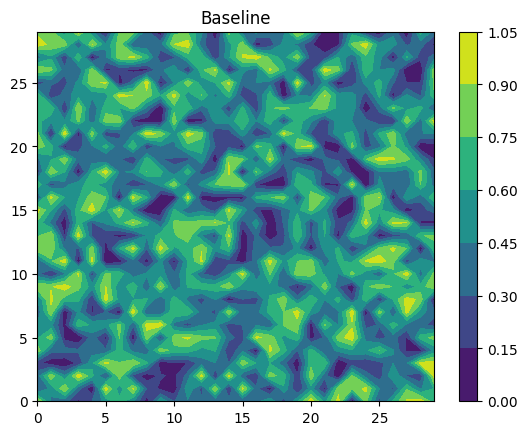

In [111]:
#
# create a baseline here for IG
#
print(indata[0].shape)
#baseline = tf.zeros(shape=indata[0].shape,dtype=tf.float32)
baseline = tf.random.uniform(shape=indata[0].shape, minval=0.0, maxval=1.0,dtype=tf.float32)
plt.contourf(baseline[:,:,11])
plt.title("Baseline")
plt.colorbar()
plt.show()

In [112]:
#
# create a difference between input data and baseline for IG cacluation.
#
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation() below.
def interpolate_images(baseline,
                       image,
                       alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)  
    input_x = tf.expand_dims(image, axis=0)
    #tf.cast(input_x, tf.float32)    
    #print(baseline_x.dtype, input_x.dtype)  
    delta = input_x - baseline_x
    images = baseline_x +  alphas_x * delta
    return images

In [113]:
print(baseline.shape, indata[0].shape)
interpolated_images = interpolate_images(
    baseline=baseline,
    image=indata[0].astype(np.float32),
    alphas=alphas)
print(interpolated_images.shape)

(30, 30, 12) (30, 30, 12)
(51, 30, 30, 12)


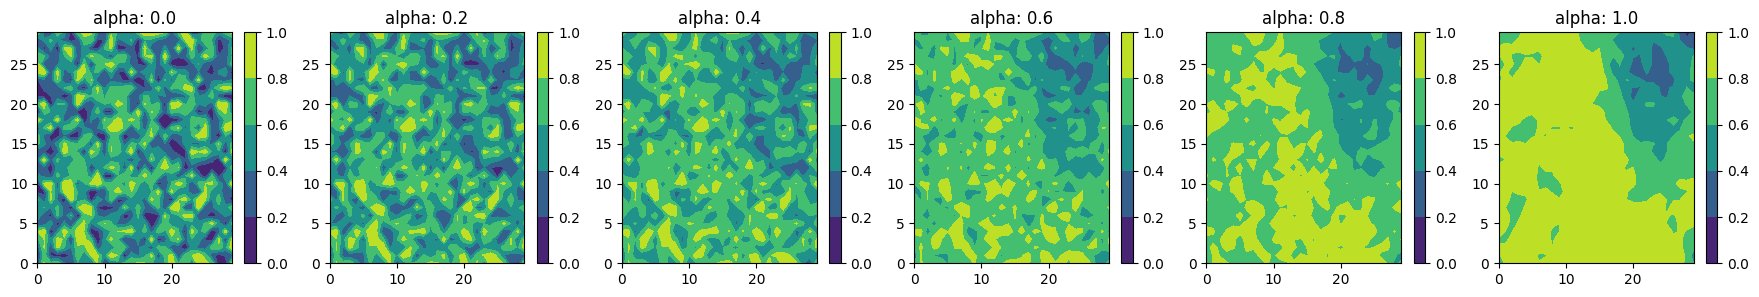

In [114]:
fig = plt.figure(figsize=(22, 3))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
    i += 1
    plt.subplot(1, len(alphas[0::10]), i)
    plt.title(f'alpha: {alpha:.1f}')
    levels = [0, 0.2, 0.4, 0.6, 0.8, 1.0]  
    plt.contourf(image[:,:,1],levels)
    plt.colorbar()
    #plt.axis('off')
plt.show();

In [115]:
def compute_gradients(images, target_class_idx):
    with tf.GradientTape() as tape:
      tape.watch(images)
      logits = model(images)
      probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
    print(images.shape,logits.shape)   
    return tape.gradient(probs, images)

In [116]:
path_gradients = compute_gradients(
    images=interpolated_images,
    target_class_idx=0) # index 0 because this is just yes/no prediction
print(path_gradients.shape)

(51, 30, 30, 12) (51, 1)
(51, 30, 30, 12)


In [117]:
pred = model(interpolated_images)
pred_proba = tf.nn.softmax(pred, axis=-1)[:, 0]
#pred_np = pred_proba.numpy()
pred_np = np.squeeze(pred.numpy(), axis=1)
print(pred.shape,pred_proba.shape,pred_np.shape)

(51, 1) (51,) (51,)


(51, 1) (51,) (51,) (51,) (50,)


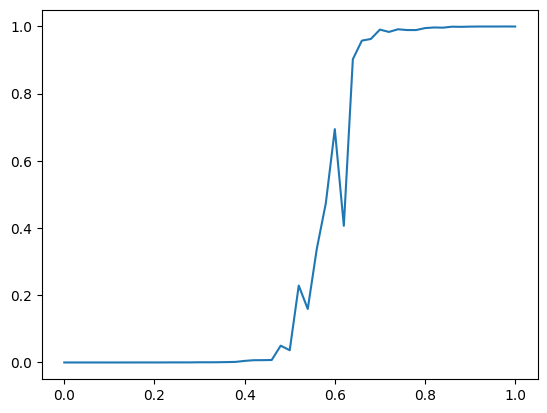

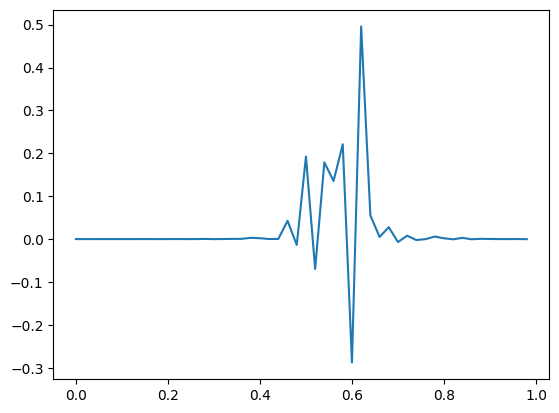

In [118]:
pred_diff = pred_np[1:]-pred_np[:-1]
print(pred.shape, pred_proba.shape, alphas.shape,pred_np.shape,pred_diff.shape)
plt.figure()
plt.plot(alphas,pred_np)
plt.figure()
plt.plot(alphas[:-1],pred_diff)
plt.show()

['OVERLOADABLE_OPERATORS', '_USE_EQUALITY', '__abs__', '__add__', '__and__', '__annotations__', '__array__', '__array_priority__', '__bool__', '__class__', '__complex__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__div__', '__doc__', '__eq__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__index__', '__init__', '__init_subclass__', '__int__', '__invert__', '__iter__', '__le__', '__len__', '__long__', '__lt__', '__matmul__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__nonzero__', '__or__', '__pow__', '__radd__', '__rand__', '__rdiv__', '__reduce__', '__reduce_ex__', '__repr__', '__rfloordiv__', '__rmatmul__', '__rmod__', '__rmul__', '__ror__', '__round__', '__rpow__', '__rsub__', '__rtruediv__', '__rxor__', '__setattr__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__tf_tracing_type__', '__truediv__', '__weakref__', '__xor__', '_add_consumer',

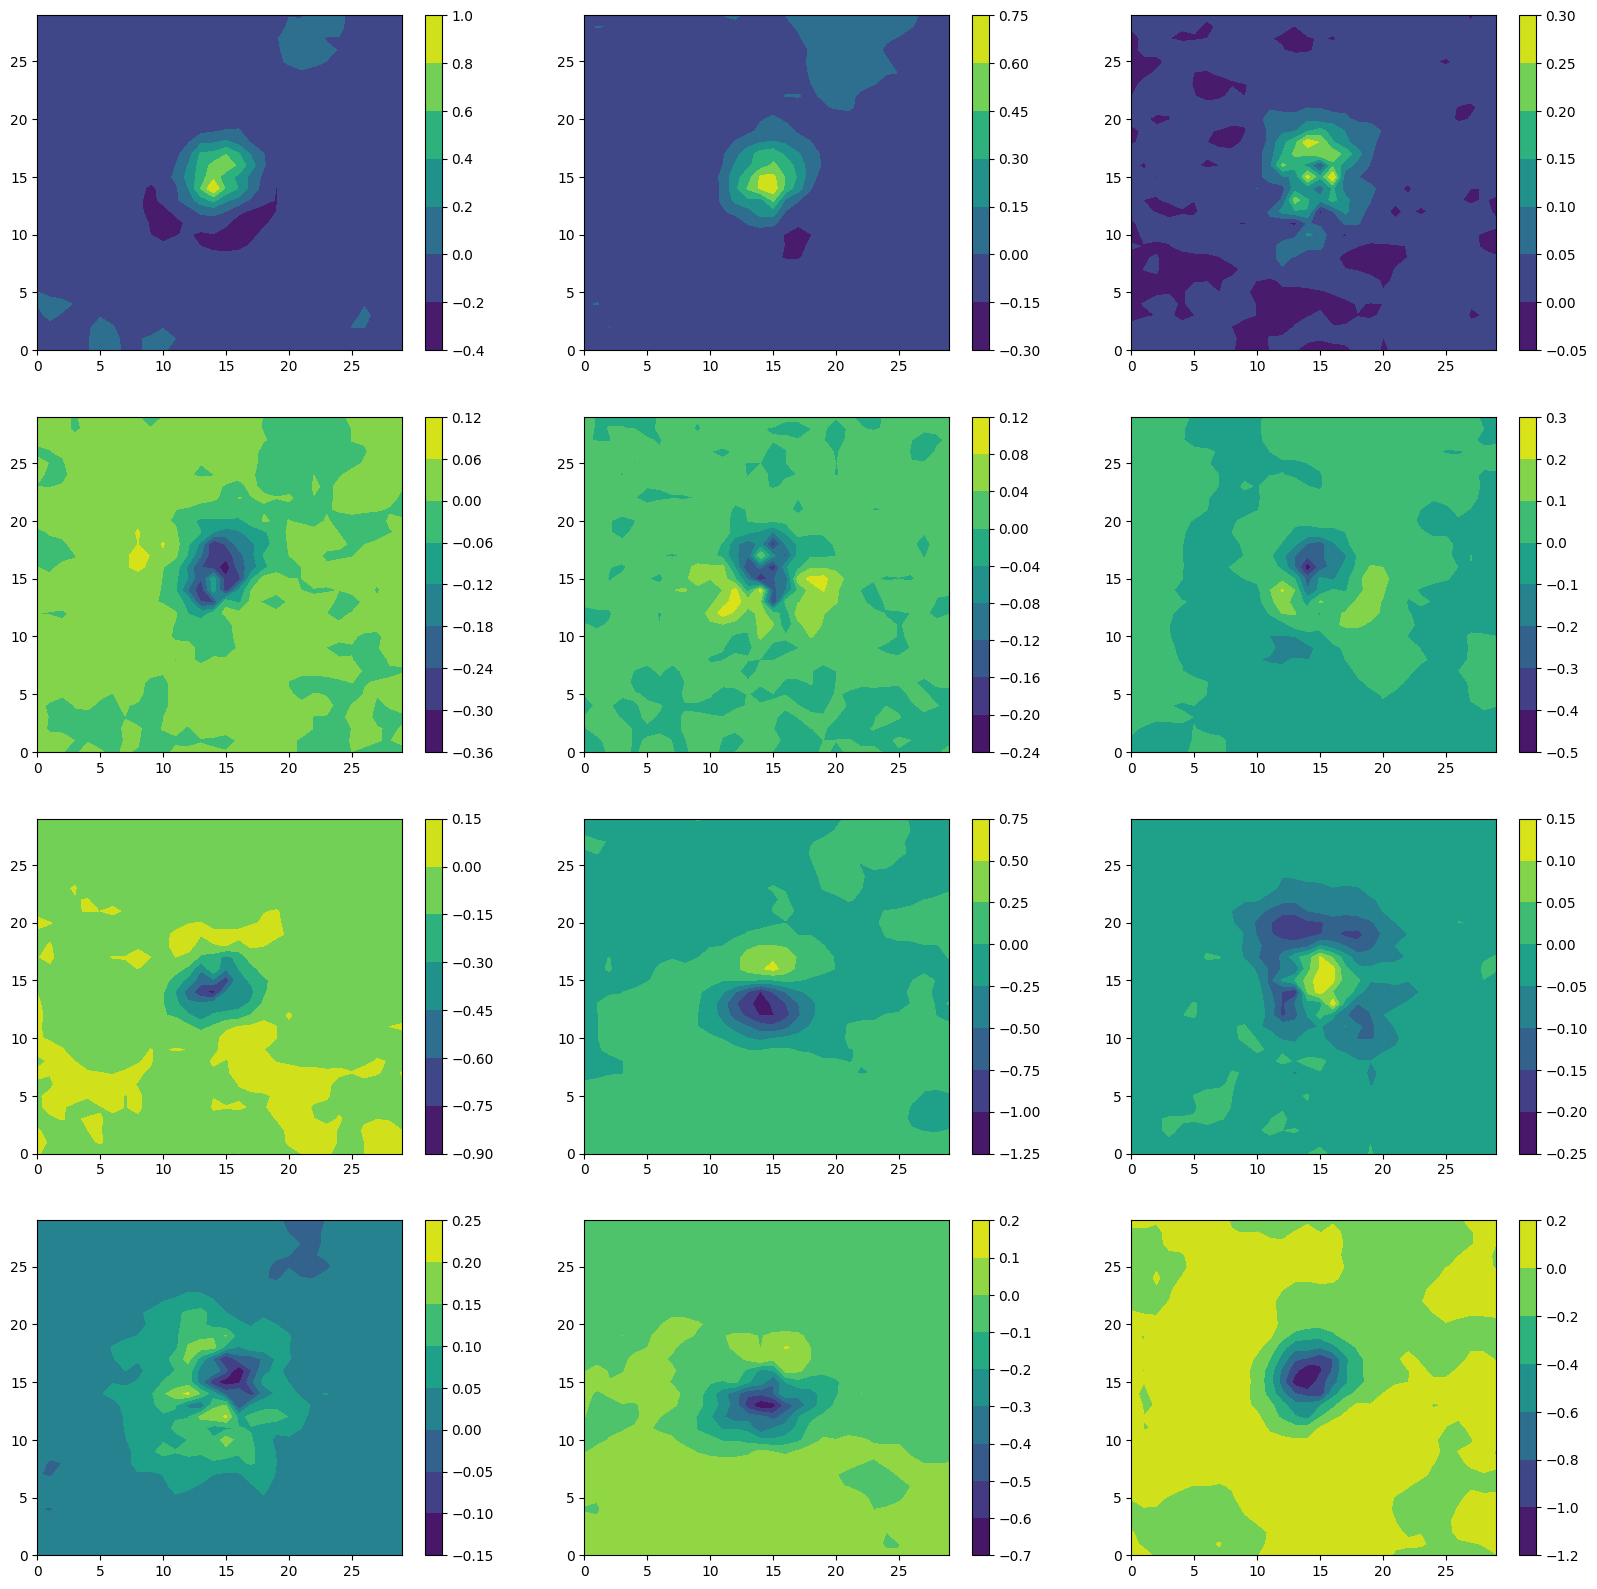

In [124]:
def integral_approximation(gradients):
  # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients
ig = integral_approximation(
    gradients=path_gradients)
#print(ig.shape)
#levels = [0, 0.02, 0.06, 0.09, 0.12]
#colors = ['w', 'b', 'g', 'r']
#plt.contourf(ig[:,:,1],levels,colors=colors)
fig = plt.figure(figsize=(20, 20))
print(dir(ig))
ig /= np.max(ig)
for i in range(12):    
    plt.subplot(4, 3, i+1)
    plt.contourf(ig[:,:,i])
    plt.colorbar()
plt.show()